In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2



def printime(title):
    print("{0}: {1}".format(title, datetime.datetime.now()))

In [2]:
latesub = pd.read_csv("../input/wheat-latesub/submission.csv")
print("Trained model summary output shape:",latesub.shape)
imageid_count = latesub['image_id'].value_counts()
print("Example dataset image count: ",len(imageid_count))
print(imageid_count)
latesub.head()

Trained model summary output shape: (282, 2)
Example dataset image count:  10
348a992bb    38
53f253011    33
796707dd7    32
f5a1f0358    30
2fd875eaa    29
cc3532ff6    28
cb8d261a3    27
51b3e36ab    25
aac893a91    22
51f1be19e    18
Name: image_id, dtype: int64


,image_id,PredictionString
0,796707dd7,0.6988 658 75 80 75
1,796707dd7,0.7250 765 875 101 94
2,796707dd7,0.7013 949 378 106 87
3,796707dd7,0.6868 550 836 88 100
4,796707dd7,0.6952 523 317 104 96


In [3]:
latesub["PredictionString"] = latesub["PredictionString"].str.split(' ')
latesub.head()

,image_id,PredictionString
0,796707dd7,"[0.6988, 658, 75, 80, 75]"
1,796707dd7,"[0.7250, 765, 875, 101, 94]"
2,796707dd7,"[0.7013, 949, 378, 106, 87]"
3,796707dd7,"[0.6868, 550, 836, 88, 100]"
4,796707dd7,"[0.6952, 523, 317, 104, 96]"


In [4]:
def preparingdf(df):
    iou = []
    tx = []
    ty = []
    tw = []
    th = []
    for i in df.iterrows():
        idx0 = i[1][1][0]
        idx1 = i[1][1][1]
        idx2 = i[1][1][2]
        idx3 = i[1][1][3]
        idx4 = i[1][1][4]
        iou.append(idx0)
        tx.append(idx1)
        ty.append(idx2)
        tw.append(idx3)
        th.append(idx4)
        
    df[['iou']] = iou
    df[['tx']] = tx
    df[['ty']] = ty
    df[['tw']] = tw
    df[['th']] = th

    return df


data = preparingdf(latesub)
data.iou = data.iou.astype(float)
data.tx = data.tx.astype(float)
data.ty = data.ty.astype(float)
data.tw = data.tw.astype(float)
data.th = data.th.astype(float)
data.head()

,image_id,PredictionString,iou,tx,ty,tw,th
0,796707dd7,"[0.6988, 658, 75, 80, 75]",0.6988,658.0,75.0,80.0,75.0
1,796707dd7,"[0.7250, 765, 875, 101, 94]",0.7250,765.0,875.0,101.0,94.0
2,796707dd7,"[0.7013, 949, 378, 106, 87]",0.7013,949.0,378.0,106.0,87.0
3,796707dd7,"[0.6868, 550, 836, 88, 100]",0.6868,550.0,836.0,88.0,100.0
4,796707dd7,"[0.6952, 523, 317, 104, 96]",0.6952,523.0,317.0,104.0,96.0


In [5]:
data.groupby(['image_id'])['iou'].max()

image_id
2fd875eaa    0.8152
348a992bb    0.7839
51b3e36ab    0.7848
51f1be19e    0.6751
53f253011    0.7648
796707dd7    0.7250
aac893a91    0.7072
cb8d261a3    0.7902
cc3532ff6    0.7755
f5a1f0358    0.7507
Name: iou, dtype: float64

In [6]:
df = data.groupby(['image_id']).mean()
df[['count']] = imageid_count
df[['iou_min']] = data.groupby(['image_id'])['iou'].min()
df[['iou_max']] = data.groupby(['image_id'])['iou'].max()
df[['tw_min']] = data.groupby(['image_id'])['tw'].min()
df[['tw_max']] = data.groupby(['image_id'])['tw'].max()
df[['th_min']] = data.groupby(['image_id'])['th'].min()
df[['th_max']] = data.groupby(['image_id'])['th'].max()

df.head()

,iou,tx,ty,tw,th,count,iou_min,iou_max,tw_min,tw_max,th_min,th_max
image_id,,,,,,,,,,,,
2fd875eaa,0.693383,488.103448,577.137931,82.689655,74.724138,29,0.5149,0.8152,26.0,136.0,22.0,131.0
348a992bb,0.661097,484.763158,565.710526,83.000000,75.526316,38,0.5523,0.7839,43.0,138.0,34.0,101.0
51b3e36ab,0.666700,478.040000,538.840000,138.960000,128.240000,25,0.5413,0.7848,67.0,329.0,71.0,288.0
51f1be19e,0.615394,556.444444,550.833333,109.500000,115.833333,18,0.5157,0.6751,51.0,197.0,66.0,219.0
53f253011,0.673512,472.636364,543.787879,106.333333,111.757576,33,0.5251,0.7648,30.0,198.0,26.0,219.0


In [7]:
test_dir = "../input/global-wheat-detection/test/"
testfile = os.listdir(test_dir)

In [8]:
img = cv2.imread(test_dir+testfile[2])
img.shape

(1024, 1024, 3)

In [9]:
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

l = lab[:,:,0]
a = lab[:,:,1]
b = lab[:,:,2]

(array([    0.,    35.,   299.,  3529.,  5073.,  5818.,  5717.,  8808.,
         3248., 10673., 15014.,  7374., 15551.,  8596., 21225., 12857.,
        18754., 11585., 20618.,  9394., 17840., 18301., 11646., 15085.,
        10102., 16390., 10188., 18019., 11191., 16814., 16615., 11334.,
        17477., 11596., 16204., 10323., 15523., 10919., 16427., 10238.,
        15837., 14456., 10377., 14860., 10527., 17480., 11433., 15538.,
        10745., 15675., 16835., 10806., 15987.,  9601., 15045., 10310.,
        14760., 10351., 14345., 10117., 13328., 13103.,  8204., 12229.,
         8173., 12812.,  8353., 12600.,  8244., 13415., 13471.,  8656.,
        13377.,  8752., 12768.,  7662., 11983.,  7586., 11529.,  7687.,
        11327., 10797.,  6923., 10086.,  6596.,  9627.,  5737.,  8192.,
         5025.,  6759.,  5828.,  3346.,  4256.,  2239.,  2625.,  1182.,
         1385.,   612.,   516.,   101.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

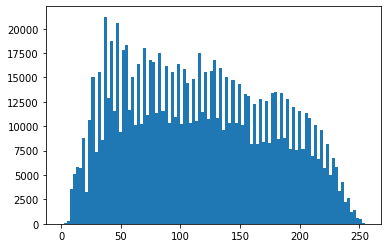

In [10]:
# First Case
plt.hist(l.flat, bins=100, range=(0,255))

(array([  444.,  3785.,  4196.,  7920.,  5945.,  9677.,  6791., 10571.,
         7133., 11228., 11603.,  7952., 12381.,  8407., 13136.,  9106.,
        13731.,  9341., 14181.,  9426., 14461., 14410.,  9810., 14637.,
         9620., 14485.,  9479., 14147.,  9388., 13907., 13674.,  9038.,
        13676.,  9135., 13868.,  9531., 14312.,  9504., 14136.,  9489.,
        14092., 13831.,  9109., 13777.,  9283., 13876.,  9490., 14511.,
         9709., 14824., 14979.,  9848., 14917.,  9930., 15183., 10395.,
        15268., 10191., 15104., 10059., 14768., 14654.,  9758., 14570.,
         9789., 14452.,  9706., 14656.,  9893., 14823., 14709.,  9688.,
        14489.,  9401., 13843.,  9021., 13036.,  8466., 12338.,  8320.,
        12285., 11588.,  7547., 10869.,  7124., 10048.,  6469.,  9232.,
         5825.,  8422.,  8226.,  5108.,  7399.,  4604.,  6695.,  4122.,
         5909.,  3778.,  4745.,  2164.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

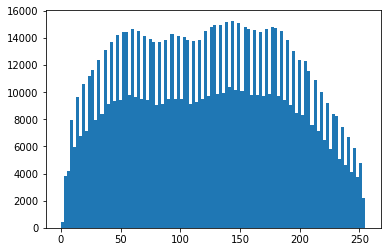

In [11]:
# AND CLAHE
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16,16))
clahe_img = clahe.apply(l)

plt.hist(clahe_img.flat, bins=100, range=(0,255))

In [12]:
img_result = cv2.merge((clahe_img,a,b))
imgNORM = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
imgCLAHE = cv2.cvtColor(img_result, cv2.COLOR_LAB2RGB)

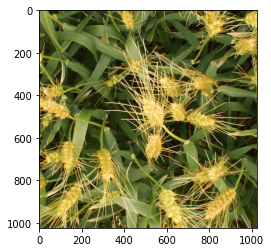

In [13]:
#Orginal
plt.imshow(imgNORM)

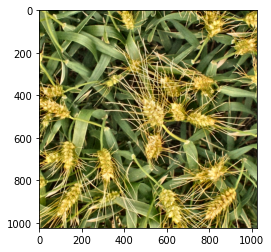

In [14]:
#After
plt.imshow(imgCLAHE)

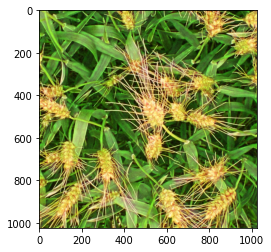

In [15]:
# AND apply CLAHE ONLY GREEN CHANNEL
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(64,64))
#clahe_img0 = clahe.apply(img[:,:,0])
clahe_img1 = clahe.apply(img[:,:,1])
#clahe_img2 = clahe.apply(img[:,:,2])

img_result = cv2.merge((img[:,:,0],clahe_img1,img[:,:,2]))
img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
plt.imshow(img_result)

In [16]:
imgCLAHE.shape

(1024, 1024, 3)

In [17]:
def inorm(im):
    im = im/(im.max()-im.min())
    return im

def rgb_density(img):
    img = inorm(img)
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    s = img.sum()
    d1 = r.sum()/s
    d2 = g.sum()/s
    d3 = b.sum()/s
    return [d1,d2,d3]
    
rgb_density(imgNORM)
    

[0.40859725606511466, 0.40477367981071727, 0.18662906412416708]

In [18]:
rgb_density(imgCLAHE)

[0.4018211292702259, 0.39932630310961476, 0.1988525676201593]

In [19]:
rgb_density(img_result)

[0.38156073120808914, 0.44418449565220386, 0.1742547731397078]

YARARLANILAN KAYNAKLAR  
https://medium.com/@ahmetkumas1/histogram-equalization-clahe-69cc9f83670c
https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html